<a href="https://colab.research.google.com/github/JSJeong-me/Uniinfo-Machine-Vision/blob/main/U0805/kaggle_cv_lec02_convolution_and_relu-uni.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
from itertools import product

def show_kernel(kernel, label=True, digits=None, text_size=28):
    # 형식 커널(Format Kernel)
    kernel = np.array(kernel)
    if digits is not None:
        kernel = kernel.round(digits) # round(): 반올림
    
    # 도식화 커널(Plot Kernel)
    cmap = plt.get_cmap('Blues_r') # get_cmap() : 괄호 안의 색조합을 불러옴
    plt.imshow(kernel, cmap=cmap)
    rows, cols = kernel.shape
    thresh = (kernel.max() + kernel.min())/2
    
    # 조건에 따라 값의 레이블 달기
    if label:
        for i,j in product(range(rows), range(cols)):
            val = kernel[i, j]
            color = cmap(0) if val > thresh else cmap(255)
            plt.text(j, i, val,
                    color = color, size = text_size,
                    horizontalalignment = 'center', verticalalignment = 'center')
    
    plt.xticks([])
    plt.yticks([])

# 소개  
저번 레슨에서는 합성곱 분류자가 2개의 파트로 - 합성곱 베이스와 dense 레이어로 이루어진 헤드 - 나누어졌음을 확인했다. 베이스는 이미지에서 시각적 특성을 추출하고, 이를 사용하여 헤드로 이미지를 분류한다.    

앞으로 합성곱 이미지 분류자에서 가장 중요한 두 가지 레이어를 학습할 것이다. 이는 **ReLU 활성화를 적용한 활성화 레이어**와 **최대 풀링 레이어**이다. 5번째 강의에서는 이 레이어들로 구성된 블록을 특성 추출에 활용하여 새로운 합성곱 신경망을 만드는 방법을 배울 것이다.

# 특성 추출  
합성곱을 자세히 살펴보기 전, 신경망 내 레이어들의 목적을 살펴보자. 우리는 합성곱, ReLU, 최대 풀링 이 3가지의 작용(operation)이 어떻게 특성 추출 과정에 사용되는지를 볼 것이다.  
  
베이스에서의 특성 추출은 다음과 같은 3개의 기본 작용으로 이루어진다.  
1. 이미지의 특정한 특성을 찾기 위해 필터를 적용한다. (합성곱)  
2. 필터링된 이미지에서 해당 특성을 찾는다. (ReLU)  
3. 특성을 극대화하기 위해 이미지를 압축한다. (최대 풀링)  
  
다음 이미지가 이 작용을 시각화하여 보여준다. 합성곱, ReLU, 최대 풀링을 통해 원래의 이미지에서 특정한 특성을 찾아낼 수 있다. (이 예시의 경우엔, 수평의 직선들을 찾는다.)  
  
<figure>
<!-- <img src="./images/2-show-extraction.png" width="1200" alt="An example of the feature extraction process."> -->
<img src="https://i.imgur.com/IYO9lqp.png" width="600" alt="An example of the feature extraction process.">
<figcaption style="textalign: center; font-style: italic"><center>특성 추출의 3가지 단계.</center></figcaption>
</figure>

# 합성곱으로 필터링 하기  
합성곱 레이어는 필터링을 한다. 케라스 모델로 합성곱 레이어를 정의하면 아래와 같다.

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = 3)
])

In [ ]:
# model.summary()

이 파라미터들은 레이어의 가중치(weights)와 활성화(activation)의 관계를 살펴보면 이해할 수 있다.

## 가중치(Weight)  
합성곱 신경망이 훈련 과정에서 학습하는 가중치는 일차적으로 합성곱 레이어에 포함된다. 이 가중치를 우리는 '커널(kernel)'이라고 부른다. 커널은 작은 어레이(행렬)로 표현할 수 있다.  
<figure>
<!-- <img src="./images/3-kernel.png" width="150" alt="A 3x3 kernel."> -->
<img src="https://i.imgur.com/uJfD9r9.png" width="150" alt="A 3x3 kernel.">
</figure>  
커널은 이미지 위를 스캔하며 픽셀값들의 '가중치가 적용된 합(weighted sum)'을 계산한다. 즉 커널은 특정 패턴을 강조하거나 덜 강조하는 편광된 렌즈의 역할을 하는 것이다.  
<figure>
<!-- <img src="./images/3-kernel-lens.png" width="400" alt="A kernel acts as a kind of lens."> -->
<img src="https://i.imgur.com/j3lk26U.png" width="250" alt="A kernel acts as a kind of lens.">
<figcaption style="textalign: center; font-style: italic"><center>커널은 편광된 렌즈의 역할을 한다.</center></figcaption>
</figure>
  
  
커널은 합성곱 레이어가 뒤따른 레이어와 어떻게 연결되는지를 정의한다. 위 그림에서의 커널은 출력에서의 각 뉴런을 입력에서 9개의 뉴런과 연결짓는다. 커널의 차원을 kernel_size로 정의하여 합성곱 신경망이 어떻게 이러한 연결을 지을지 정한다. 대부분 커널은 홀수의 차원을 가진다. 즉 kernel_size = (3,3) 또는 (5,5)가 되어 가운데에 하나의 픽셀이 위치하도록 하지만 필수 사항은 아니다.  
  
합성곱 레이어의 커널은 어떤 특성을 추출할지를 결정한다. 훈련 과정에서 합성곱 레이어는 분류 문제를 해결하기 위해 어떤 특성이 필요한지를 정하려고 한다. 이는 즉 커널에게 가장 최적화된 값을 찾는 것을 의미한다. 

## 활성화  
신경망의 활성화(activation)는 '특성 맵(feature map)'이라고 부른다. 이는 이미지에 필터를 적용한 결과를 뜻한다. 즉, 특성 맵은 커널이 추출하는 특정한 시각적 특성을 지닌다. 아래는 몇 개의 필터와 각 필터를 적용한 특성 맵을 보여준다.  
  
<figure>
<img src="https://i.imgur.com/JxBwchH.png" width="800" alt="Three kernels and the feature maps they produce."><figcaption style="textalign: center; font-style: italic"><center>커널과 특성.</center></figcaption>
</figure>  
  
커널이 가지는 값들의 패턴으로 인해 어떤 특성 맵을 만들지를 예상할 수 있다. 보편적으로 입력 이미지에서 합성곱이 강조하는 바는 커널의 '양의 숫자들'이 이루는 모양과 비슷하다. 따라서 위 예시에서 왼쪽과 중간의 커널은 수평의 모양을 필터링 할 것이다.  
  
filter 변수로 합성곱 레이어가 얼마나 많은 특성 맵을 출력해야 하는지를 정의할 수 있다. 

# ReLU로 감지하기  
필터링을 거친 후, 특성 맵은 활성화 함수를 지난다. 정류화 함수(rectifier function)는 아래와 같은 그래프를 띈다.  
<figure>
<!-- <img src="./images/relu.png" width="300" alt=""> -->
<img src="https://i.imgur.com/DxGJuTH.png" width="300" alt="Graph of the ReLU activation function.">
<figcaption style="textalign: center; font-style: italic"><center>정류화 함수는 '정류된' 음의 값들이 전부 0으로써 x축과 평행한 직선의 형태를 띈다.</center></figcaption>
</figure>
  
  정류화 함수가 더해진 뉴런은 '정류화 선형 유닛(rectified linear unit)'이라고 부른다. 이름 덕택에 정류화 함수를 'ReLU 활성화(activation)'또는 'ReLU 함수'라고 부르기도 한다.  
  
  ReLU 활성화는 활성화 레이어에서 그 자체로만 정의할수도 있지만, 대부분 Conv2D의 활성화 함수로써 합성곱 레이어에 포함된다.

In [4]:
model = keras.Sequential([
    layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')
    # 이후 더 많은 레이어가 추가될 것이다.
])

활성화 함수는, 중요도에 따라 특정한 픽셀 값을 지정하는 함수로 생각할 수 있다. ReLU 활성화는 음의 값은 중요하지 않기 때문에 0으로 지정한다. ('중요하지 않은 모든 값들은 동일하게 중요하지 않다')  
아래는 위의 특성 맵에 ReLU가 적용된 모습을 보여준다. 각 특성을 두드러지게 나타내었다는 것을 확인할 수 있다.  
<figure>
<!-- <img src="./images/3-relu-and-maps.png" width="800" alt="ReLU applied to feature maps."> -->
<img src="https://i.imgur.com/dKtwzPY.png" width="800" alt="ReLU applied to feature maps.">
</figure>  
다른 활성화 함수처럼 ReLU 함수는 비선형이다. 이는 신경망의 모든 레이어의 통합된 효과(effect)가 단순히 각 레이어의 효과를 전부 더한 것과 일치하지 않는다는 것을 의미한다. 활성화 함수의 비선형성은 신경망이 깊어질수록 특성들이 '흥미롭게 통합되도록' 한다. 

# 예시 - 합성곱과 ReLU 적용하기  
특성 추출을 직접해보면서 합성곱 신경망의 이면에는 어떤 일들이 일어나는지 자세히 알아볼 수 있다.   
아래는 이번 예시에서 사용할 이미지이다.

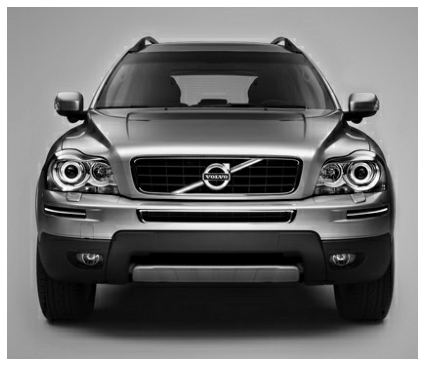

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('figure', autolayout = True)
plt.rc('axes', labelweight = 'bold', labelsize = 'large',
      titleweight = 'bold', titlesize = 18, titlepad = 10)
plt.rc('image', cmap = 'magma')

image_path = './car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image), cmap = 'gray')
plt.axis('off')
plt.show()

필터링 단계에서는, 커널을 정의하고 합성곱에 커널을 적용한다. 예시에 사용될 커널은 '가장자리를 추출하는' 커널이다. 넘파이에서 행렬을 np.array로 정의하듯 커널은 tf.constant로 정의할 수 있다. 이를 통해 텐서플로우가 사용할 텐서를 만들 수 있다.

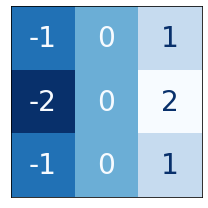

In [7]:
import tensorflow as tf

kernel = tf.constant([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

plt.figure(figsize = (3,3))
show_kernel(kernel)

텐서플로우는 신경망이 주로 하는 대부분의 작용/계산들을 tf.nn 모듈에 가지고 있다. 예시에서 사용할 모듈은 conv2d와 relu이다. 이는 케라스 레이어의 함수 버전이라고 생각하면 된다.  
  
  다음 숨겨진 셀(레이어)에서는 텐서플로우에서의 원활한 사용을 위해 이미지의 형식을 변형시킨다. 예시를 위해서는 중요한 내용이 아니다.

In [8]:
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)

kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

이제 커널을 적용하여 어떤 일이 생기는지 살펴보자.

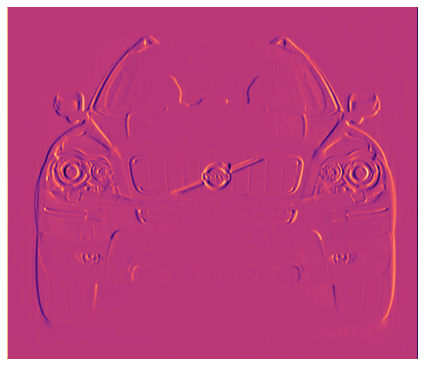

In [9]:
image_filter = tf.nn.conv2d(
    input = image,
    filters = kernel,
    strides = 1,
    padding = 'SAME'
)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.show();

다음은 ReLU 함수로 특성을 감지하는 단계이다. 파라미터를 사전에 설정할 필요가 없어 합성곱보다 훨씬 간단하다.

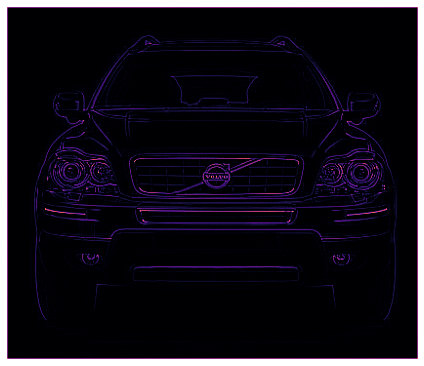

In [ ]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize = (6,6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.show();

드디어 특성 맵을 만들 수 있었다. 이런 이미지(특성 맵)들이 헤드가 분류 문제를 해결하기 위해 사용하는 것들이다. 우리는 어떤 특성은 '차'에 특징적이고, 또 다른 특성은 '트럭'에 특징적일 것이라고 예상할 수 있다. 합성곱 신경망이 이런 특성을 찾아내는 커널을 만드는 것이다.